#  CE-40959: Deep Learning

## Homework 5 - 1: VAE

The goal is to VAE!!!!

Good luck

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

---

In [15]:
CUDA = True
BATCH_SIZE = 128
LEARNING_RATE = 0.01

---

In [16]:
# Reproducibility options

np.random.seed(0)
torch.manual_seed(0)

if CUDA:
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

---

In [17]:
# MNIST Dataset
original_train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
original_test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=True)

In [18]:
# Define Train loader
train_tensors = original_train_dataset.data.float() / 255
test_tensors = original_test_dataset.data.float() / 255

# Define Datasets
train_dataset = torch.utils.data.TensorDataset(train_tensors, original_train_dataset.targets)
test_dataset = torch.utils.data.TensorDataset(test_tensors, original_test_dataset.targets)

# Define dataloaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

---

In [44]:
class VAE(nn.Module):
    def __init__(self, input_dim, encoder_dims, z_dim, decoder_dims, dropout_rate=0.2):
        super(VAE, self).__init__()
        
        self.input_dim = input_dim
        self.z_dim = z_dim
        
        ########################## TODO ##########################
        # self.input_dropout must be a dropout module with p=dropout_rate
        self.input_dropout = nn.Dropout2d(p=dropout_rate)
        ######################## END TODO ########################
        
        # Encoder part
        encoder_layers = []
        ########################## TODO ##########################
        # Define encoder layers and add them to `encoder_layers`
        # Use ReLU for activation functions
        encoder_layers.append(nn.Linear(input_dim, encoder_dims[0]))
        encoder_layers.append(nn.ReLU())
        for i in range(1, len(encoder_dims)):
            encoder_layers.append(nn.Linear(encoder_dims[i-1], encoder_dims[i]))
            encoder_layers.append(nn.ReLU())
        ######################## END TODO ########################
        self.encoder = nn.Sequential(*encoder_layers)
        
        encoder_last_dim = ([input_dim] + encoder_dims)[-1]
        
        # mu and log_var
        ########################## TODO ##########################
        # Define mu and log_var layers
        # They do not need any activation function
        self.mu_layer = nn.Linear(encoder_last_dim, z_dim)
        self.log_var_layer = nn.Linear(encoder_last_dim, z_dim)
        ######################## END TODO ########################
        
        # Decoder part
        decoder_layers = []
        ########################## TODO ##########################
        # Define decoder layers and add them to `decoder_layers`
        # Use ReLU for activation functions
        # Last layer does not need any activation function
        decoder_layers.append(nn.Linear(z_dim, decoder_dims[0]))
        decoder_layers.append(nn.ReLU())
        for i in range(1, len(decoder_dims)):
            decoder_layers.append(nn.Linear(decoder_dims[0], decoder_dims[1]))
            decoder_layers.append(nn.ReLU())
        decoder_layers.append(nn.Linear(decoder_dims[-1], input_dim))
        ######################## END TODO ########################
        self.decoder = nn.Sequential(*decoder_layers)

    @staticmethod
    def _sampling(mu, log_var):
        """
        This function is in charge of reparametrization trick
        """
        ########################## TODO ##########################
        # Generate a random z from N(mu=mu, var=e^log_var)
#         eps = torch.normal(torch.zeros_like(mu), torch.ones_like(mu))
        eps = torch.randn_like(mu)
        z = mu + eps * torch.exp(0.5*log_var)
        ######################## END TODO ########################
        return z

    def forward(self, data):
        x = data.get("X")
        ########################## TODO ##########################
        # Complete the flow
        # x > dropout > encoder > mu, log_var > z > decoder > output
        dropped = self.input_dropout(x)
        encoded = self.encoder(dropped)
        mu = self.mu_layer(encoded)
        log_var = self.log_var_layer(encoded)
        z = self._sampling(mu, log_var)
        output = self.decoder(z)
        ######################## END TODO ########################
        return {"X": output, "mu": mu, "log_var": log_var, "z": z}
    
    def loss(self, data, output):
      x = data.get("X")
      recon_x = output.get("X")
      mu = output.get("mu")
      log_var = output.get("log_var")
      ########################## TODO ##########################
      # Calculate MSE and KLD
      MSE = F.mse_loss(x, recon_x, reduction='sum')
      KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
      ######################## END TODO ########################
      return {"final": MSE + KLD, "KLD": KLD, "MSE": MSE}

---

In [45]:
def train(model, data_loader, optimizer, epoch="?", print_every=100, verbose=True):
    """
    This function trains a `model` given a `data_loader` by `optimizer`
    """
    model.train()

    train_loss = 0

    for batch_idx, batch_data in enumerate(data_loader):
        supervised_training = len(batch_data) == 2

        if supervised_training:
            # Labeled data
            data = {"X": batch_data[0],
                    "Y": batch_data[1]}
        else:
            # Unlabeled data
            data = {"X": batch_data[0]}

        # Flatten data
        ########################## TODO ##########################
        # Use `flatten` function from pytorch
        data['X'] = data['X'].flatten(start_dim=1)
        ######################## END TODO ########################

        if CUDA:
            ########################## TODO ##########################
            # Send tensors in data to GPU
            data['X'] = data['X'].cuda()
            ######################## END TODO ########################


        ########################## TODO ##########################
        # Think about this part
        ######################## END TODO ########################
        optimizer.zero_grad()

        output = model(data)
        loss = model.loss(data, output)
        final_loss = loss["final"]
        train_loss += final_loss.item()

        final_loss.backward()
        optimizer.step()
        ########################## TODO ##########################
        # Thinking ends here
        ######################## END TODO ########################

        if batch_idx % print_every == 0 and verbose:
            print('Train | Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data["X"]), len(data_loader.dataset),
                100. * batch_idx / len(data_loader), final_loss.item() / len(data["X"])))

    train_loss /= len(data_loader.dataset)
    if verbose:
        print('====> Train | Epoch: {} \t | \t Average loss: {:.4f}'.format(epoch, train_loss,))

    return {"final": train_loss}

In [46]:
def test(model, data_loader, verbose=True):
    """
    This function tests a `model` on a `data_loader`
    """
    model.eval()

    test_loss = 0

    labels, y_preds = None, None
    with torch.no_grad():
        for batch_data  in data_loader:
            supervised = len(batch_data) == 2

            if supervised:
                # Labeled data
                data = {"X": batch_data[0],
                        "Y": batch_data[1]}
            else:
                # Unlabeled data
                data = {"X": batch_data[0]}

            #  Flatten data
            ########################## TODO ##########################
            # Use `flatten` function from pytorch
            data['X'] = data['X'].flatten(start_dim=1)
            ######################## END TODO ########################

            if CUDA:
                ########################## TODO ##########################
                # Send tensors in data to GPU
                data['X'] = data['X'].cuda()
                ######################## END TODO ########################

            output = model(data)
            loss = model.loss(data, output)
            final_loss = loss["final"]
            test_loss += final_loss.item()

            # Storing y_true and y_pred if learning is supervised
            supervised = supervised and "Y" in output
            if supervised:
                y_pred = np.argmax(output["Y"].detach().cpu().numpy(), axis=1)
                y_true = data["Y"].cpu().numpy()
                if labels is None:
                    labels = y_true
                    y_preds = y_pred
                else:
                    labels = np.concatenate((labels, y_true), axis=None)
                    y_preds = np.concatenate((y_preds, y_pred), axis=None)

    test_loss /= len(data_loader.dataset)

    if supervised:
        accuracy = accuracy_score(labels, y_preds)
        if verbose:
            print('====> Test  | model loss: {:.4f}'.format(test_loss))
            print('            |   accuracy: {:.4f}'.format(100 * accuracy))
            print(classification_report(labels, y_preds))
        return {"final": test_loss, "accuracy": accuracy}
    else:
        if verbose:
            print('====> Test  | model loss: {:.4f}'.format(test_loss))
        return {"final": test_loss}

In [47]:
def run(model, parameters, n_epoch, train_loader, test_loader,
        end_function=lambda model:None):
    """
    This function will optimize `parameters` of `model` for `n_epoch` epochs
    on `train_loader` dataset and validate it on `test_loader`.
    At the end of each epoch, `end_function` will be called on `model`.
    """
    if CUDA:
        model.cuda()

    ########################## TODO ##########################
    # Initialize a new Adam optimizer.
    # Set learning rate to LEARNING_RATE / BATCH_SIZE (why?)
    optimizer = optim.Adam(parameters, lr=LEARNING_RATE / BATCH_SIZE)
    ######################## END TODO ########################

    for epoch in range(1, n_epoch + 1):
        train_loss = train(model, train_loader, optimizer, epoch)
        test_loss = test(model, test_loader)
        end_function(model)

In [48]:
def show(image_batch, rows=1):
    # Set Plot dimensions
    cols = np.ceil(image_batch.shape[0] / rows)
    plt.rcParams['figure.figsize'] = (0.0 + cols, 0.0 + rows) # set default size of plots
    
    for i in range(image_batch.shape[0]):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(image_batch[i], cmap="gray", vmin=0, vmax=1)
        plt.axis('off')
    plt.show()

---

In [49]:
vae = VAE(784, encoder_dims=[512, 128], z_dim=32, decoder_dims=[128, 512])
print(vae)

# Output might be like:
# VAE(
#   (input_dropout): Dropout(p=0.2)
#   (encoder): Sequential(
#     (0): Linear(in_features=784, out_features=512, bias=True)
#     (1): ReLU()
#     (2): Linear(in_features=512, out_features=128, bias=True)
#     (3): ReLU()
#   )
#   (mu_layer): Linear(in_features=128, out_features=32, bias=True)
#   (log_var_layer): Linear(in_features=128, out_features=32, bias=True)
#   (decoder): Sequential(
#     (0): Linear(in_features=32, out_features=128, bias=True)
#     (1): ReLU()
#     (2): Linear(in_features=128, out_features=512, bias=True)
#     (3): ReLU()
#     (4): Linear(in_features=512, out_features=784, bias=True)
#   )
# )

VAE(
  (input_dropout): Dropout2d(p=0.2, inplace=False)
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=128, bias=True)
    (3): ReLU()
  )
  (mu_layer): Linear(in_features=128, out_features=32, bias=True)
  (log_var_layer): Linear(in_features=128, out_features=32, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=784, bias=True)
  )
)


In [50]:
def show_vae(vae):
    # Select 10 random inputs
    data_loader = train_loader
    indices = torch.randint(data_loader.dataset.tensors[0].shape[0], (10,))
    input_img = data_loader.dataset.tensors[0][indices]
    print("Inputs:")
    show(input_img.numpy())
    # Calculate reconstructions
    input_img = input_img.flatten(start_dim=1)
    if CUDA:
        input_img = input_img.cuda()
    recons_img = vae({"X": input_img})["X"]
    recons_img = recons_img.detach().cpu().view(-1, 28, 28).numpy()
    print("Reconstructions:")
    show(recons_img)
    # Generate images
    z = torch.randn(10, vae.z_dim)
    if CUDA:
        z = z.cuda()
    generated_img = vae.decoder(z)
    generated_img = generated_img.detach().cpu().view(-1, 28, 28).numpy()
    print("Generated Images:")
    show(generated_img)

Train | Epoch: 1 [0/60000 (0%)]	Loss: 101.794960
Train | Epoch: 1 [12800/60000 (21%)]	Loss: 55.730309
Train | Epoch: 1 [25600/60000 (43%)]	Loss: 53.676582
Train | Epoch: 1 [38400/60000 (64%)]	Loss: 52.724361
Train | Epoch: 1 [51200/60000 (85%)]	Loss: 50.531864
====> Train | Epoch: 1 	 | 	 Average loss: 55.8057
====> Test  | model loss: 49.1290
Inputs:


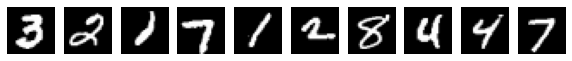

Reconstructions:


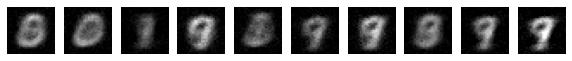

Generated Images:


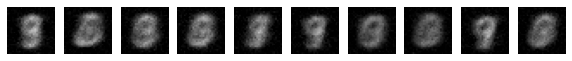

Train | Epoch: 2 [0/60000 (0%)]	Loss: 49.005096
Train | Epoch: 2 [12800/60000 (21%)]	Loss: 48.595905
Train | Epoch: 2 [25600/60000 (43%)]	Loss: 45.506798
Train | Epoch: 2 [38400/60000 (64%)]	Loss: 46.063023
Train | Epoch: 2 [51200/60000 (85%)]	Loss: 45.114033
====> Train | Epoch: 2 	 | 	 Average loss: 46.3587
====> Test  | model loss: 43.7991
Inputs:


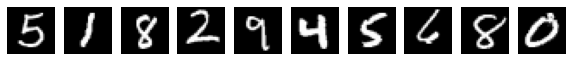

Reconstructions:


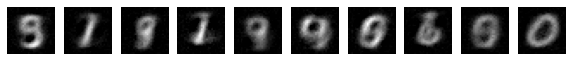

Generated Images:


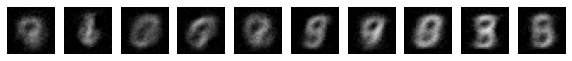

Train | Epoch: 3 [0/60000 (0%)]	Loss: 43.231995
Train | Epoch: 3 [12800/60000 (21%)]	Loss: 44.082737
Train | Epoch: 3 [25600/60000 (43%)]	Loss: 42.090485
Train | Epoch: 3 [38400/60000 (64%)]	Loss: 41.453102
Train | Epoch: 3 [51200/60000 (85%)]	Loss: 43.770767
====> Train | Epoch: 3 	 | 	 Average loss: 43.0359
====> Test  | model loss: 41.6270
Inputs:


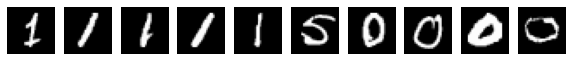

Reconstructions:


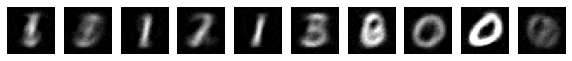

Generated Images:


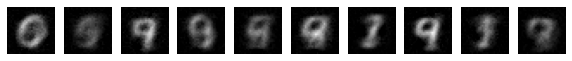

Train | Epoch: 4 [0/60000 (0%)]	Loss: 42.278778
Train | Epoch: 4 [12800/60000 (21%)]	Loss: 40.992233
Train | Epoch: 4 [25600/60000 (43%)]	Loss: 40.558155
Train | Epoch: 4 [38400/60000 (64%)]	Loss: 39.394051
Train | Epoch: 4 [51200/60000 (85%)]	Loss: 41.522369
====> Train | Epoch: 4 	 | 	 Average loss: 41.3816
====> Test  | model loss: 40.1883
Inputs:


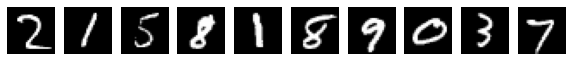

Reconstructions:


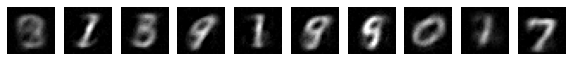

Generated Images:


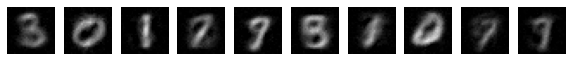

Train | Epoch: 5 [0/60000 (0%)]	Loss: 42.391251
Train | Epoch: 5 [12800/60000 (21%)]	Loss: 41.566528
Train | Epoch: 5 [25600/60000 (43%)]	Loss: 40.147877
Train | Epoch: 5 [38400/60000 (64%)]	Loss: 40.055809
Train | Epoch: 5 [51200/60000 (85%)]	Loss: 38.785477
====> Train | Epoch: 5 	 | 	 Average loss: 40.1181
====> Test  | model loss: 38.9800
Inputs:


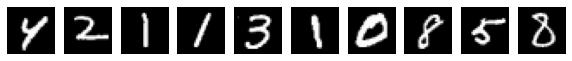

Reconstructions:


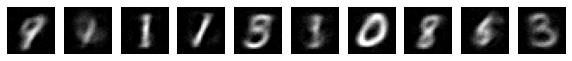

Generated Images:


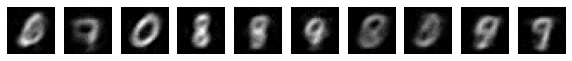

Train | Epoch: 6 [0/60000 (0%)]	Loss: 39.061729
Train | Epoch: 6 [12800/60000 (21%)]	Loss: 40.362228
Train | Epoch: 6 [25600/60000 (43%)]	Loss: 41.535656
Train | Epoch: 6 [38400/60000 (64%)]	Loss: 38.795204
Train | Epoch: 6 [51200/60000 (85%)]	Loss: 40.268734
====> Train | Epoch: 6 	 | 	 Average loss: 39.1117
====> Test  | model loss: 38.0119
Inputs:


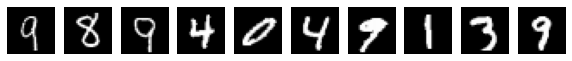

Reconstructions:


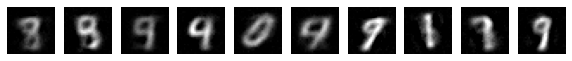

Generated Images:


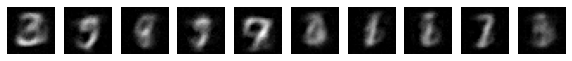

Train | Epoch: 7 [0/60000 (0%)]	Loss: 37.704670
Train | Epoch: 7 [12800/60000 (21%)]	Loss: 39.905441
Train | Epoch: 7 [25600/60000 (43%)]	Loss: 38.578579
Train | Epoch: 7 [38400/60000 (64%)]	Loss: 38.812489
Train | Epoch: 7 [51200/60000 (85%)]	Loss: 37.645988
====> Train | Epoch: 7 	 | 	 Average loss: 38.1903
====> Test  | model loss: 37.1973
Inputs:


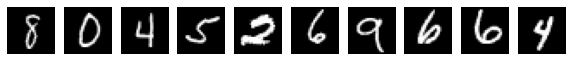

Reconstructions:


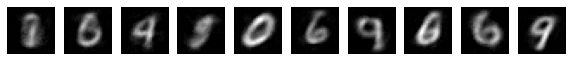

Generated Images:


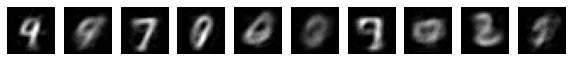

Train | Epoch: 8 [0/60000 (0%)]	Loss: 38.128708
Train | Epoch: 8 [12800/60000 (21%)]	Loss: 37.682911
Train | Epoch: 8 [25600/60000 (43%)]	Loss: 37.178638
Train | Epoch: 8 [38400/60000 (64%)]	Loss: 37.599342
Train | Epoch: 8 [51200/60000 (85%)]	Loss: 37.424446
====> Train | Epoch: 8 	 | 	 Average loss: 37.4287
====> Test  | model loss: 36.4209
Inputs:


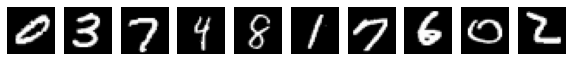

Reconstructions:


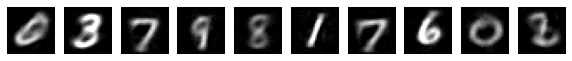

Generated Images:


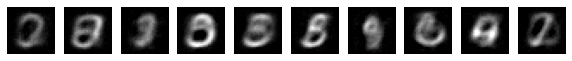

Train | Epoch: 9 [0/60000 (0%)]	Loss: 36.826309
Train | Epoch: 9 [12800/60000 (21%)]	Loss: 36.776245
Train | Epoch: 9 [25600/60000 (43%)]	Loss: 34.677719
Train | Epoch: 9 [38400/60000 (64%)]	Loss: 36.072483
Train | Epoch: 9 [51200/60000 (85%)]	Loss: 35.659107
====> Train | Epoch: 9 	 | 	 Average loss: 36.7457
====> Test  | model loss: 35.6832
Inputs:


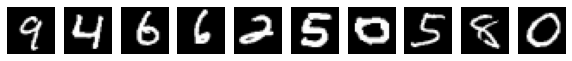

Reconstructions:


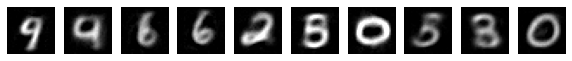

Generated Images:


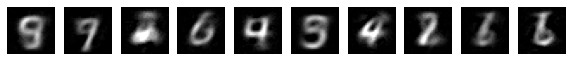

Train | Epoch: 10 [0/60000 (0%)]	Loss: 36.991081
Train | Epoch: 10 [12800/60000 (21%)]	Loss: 34.614960
Train | Epoch: 10 [25600/60000 (43%)]	Loss: 35.921875
Train | Epoch: 10 [38400/60000 (64%)]	Loss: 36.868645
Train | Epoch: 10 [51200/60000 (85%)]	Loss: 37.375435
====> Train | Epoch: 10 	 | 	 Average loss: 36.1433
====> Test  | model loss: 35.2284
Inputs:


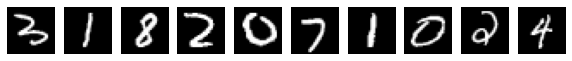

Reconstructions:


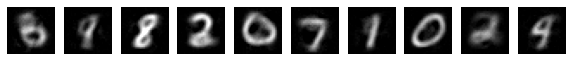

Generated Images:


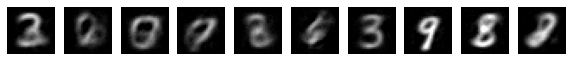

Train | Epoch: 11 [0/60000 (0%)]	Loss: 37.070732
Train | Epoch: 11 [12800/60000 (21%)]	Loss: 35.140045
Train | Epoch: 11 [25600/60000 (43%)]	Loss: 35.356144
Train | Epoch: 11 [38400/60000 (64%)]	Loss: 33.965523
Train | Epoch: 11 [51200/60000 (85%)]	Loss: 36.065071
====> Train | Epoch: 11 	 | 	 Average loss: 35.6172
====> Test  | model loss: 34.7676
Inputs:


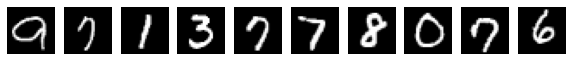

Reconstructions:


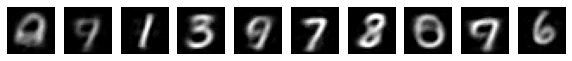

Generated Images:


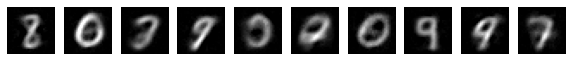

Train | Epoch: 12 [0/60000 (0%)]	Loss: 33.875263
Train | Epoch: 12 [12800/60000 (21%)]	Loss: 34.708523
Train | Epoch: 12 [25600/60000 (43%)]	Loss: 35.212921
Train | Epoch: 12 [38400/60000 (64%)]	Loss: 35.356003
Train | Epoch: 12 [51200/60000 (85%)]	Loss: 34.610329
====> Train | Epoch: 12 	 | 	 Average loss: 35.1306
====> Test  | model loss: 34.2883
Inputs:


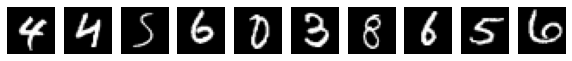

Reconstructions:


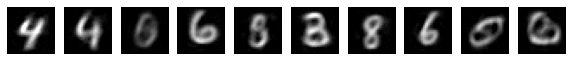

Generated Images:


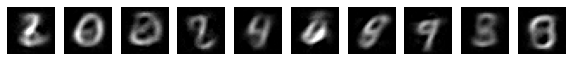

Train | Epoch: 13 [0/60000 (0%)]	Loss: 34.040581
Train | Epoch: 13 [12800/60000 (21%)]	Loss: 34.953659
Train | Epoch: 13 [25600/60000 (43%)]	Loss: 34.364616
Train | Epoch: 13 [38400/60000 (64%)]	Loss: 33.793922
Train | Epoch: 13 [51200/60000 (85%)]	Loss: 31.965359
====> Train | Epoch: 13 	 | 	 Average loss: 34.7217
====> Test  | model loss: 33.9292
Inputs:


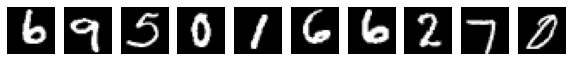

Reconstructions:


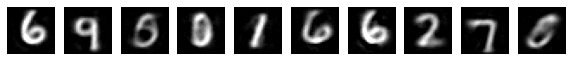

Generated Images:


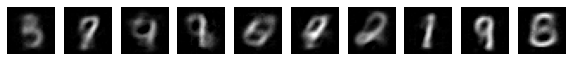

Train | Epoch: 14 [0/60000 (0%)]	Loss: 34.492317
Train | Epoch: 14 [12800/60000 (21%)]	Loss: 33.067287
Train | Epoch: 14 [25600/60000 (43%)]	Loss: 34.405746
Train | Epoch: 14 [38400/60000 (64%)]	Loss: 33.489838
Train | Epoch: 14 [51200/60000 (85%)]	Loss: 35.610085
====> Train | Epoch: 14 	 | 	 Average loss: 34.3686
====> Test  | model loss: 33.5657
Inputs:


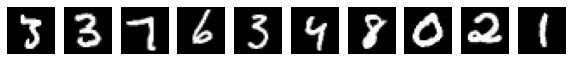

Reconstructions:


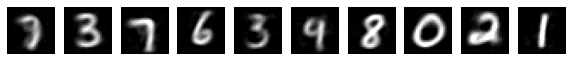

Generated Images:


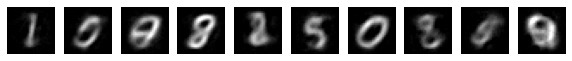

Train | Epoch: 15 [0/60000 (0%)]	Loss: 33.696968
Train | Epoch: 15 [12800/60000 (21%)]	Loss: 34.345268
Train | Epoch: 15 [25600/60000 (43%)]	Loss: 34.628990
Train | Epoch: 15 [38400/60000 (64%)]	Loss: 34.471706
Train | Epoch: 15 [51200/60000 (85%)]	Loss: 33.926414
====> Train | Epoch: 15 	 | 	 Average loss: 34.0713
====> Test  | model loss: 33.2795
Inputs:


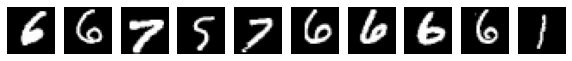

Reconstructions:


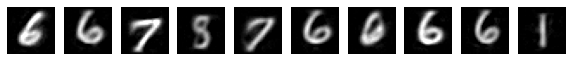

Generated Images:


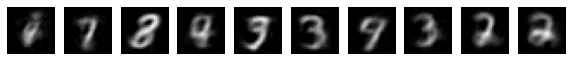

Train | Epoch: 16 [0/60000 (0%)]	Loss: 33.167461
Train | Epoch: 16 [12800/60000 (21%)]	Loss: 35.203819
Train | Epoch: 16 [25600/60000 (43%)]	Loss: 33.792831
Train | Epoch: 16 [38400/60000 (64%)]	Loss: 34.066284
Train | Epoch: 16 [51200/60000 (85%)]	Loss: 32.634674
====> Train | Epoch: 16 	 | 	 Average loss: 33.7870
====> Test  | model loss: 32.9757
Inputs:


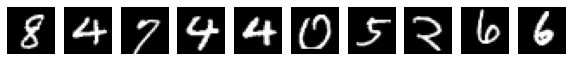

Reconstructions:


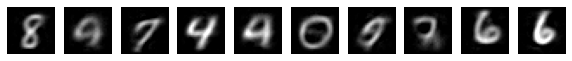

Generated Images:


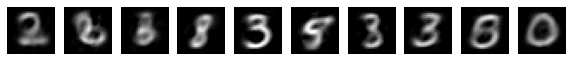

Train | Epoch: 17 [0/60000 (0%)]	Loss: 34.052010
Train | Epoch: 17 [12800/60000 (21%)]	Loss: 33.842110
Train | Epoch: 17 [25600/60000 (43%)]	Loss: 34.506447
Train | Epoch: 17 [38400/60000 (64%)]	Loss: 34.722778
Train | Epoch: 17 [51200/60000 (85%)]	Loss: 34.393246
====> Train | Epoch: 17 	 | 	 Average loss: 33.5589
====> Test  | model loss: 32.7344
Inputs:


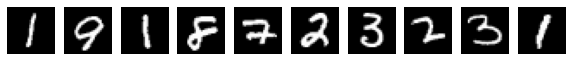

Reconstructions:


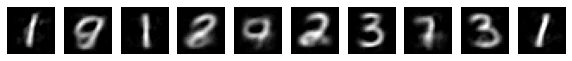

Generated Images:


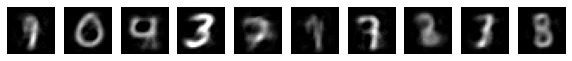

Train | Epoch: 18 [0/60000 (0%)]	Loss: 34.084419
Train | Epoch: 18 [12800/60000 (21%)]	Loss: 31.880722
Train | Epoch: 18 [25600/60000 (43%)]	Loss: 33.459293
Train | Epoch: 18 [38400/60000 (64%)]	Loss: 33.817184
Train | Epoch: 18 [51200/60000 (85%)]	Loss: 33.181999
====> Train | Epoch: 18 	 | 	 Average loss: 33.3180
====> Test  | model loss: 32.5784
Inputs:


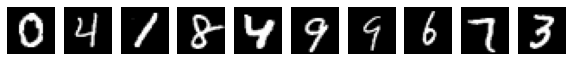

Reconstructions:


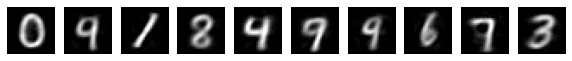

Generated Images:


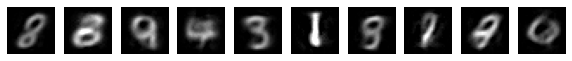

Train | Epoch: 19 [0/60000 (0%)]	Loss: 32.339661
Train | Epoch: 19 [12800/60000 (21%)]	Loss: 33.468628
Train | Epoch: 19 [25600/60000 (43%)]	Loss: 33.612617
Train | Epoch: 19 [38400/60000 (64%)]	Loss: 32.870621
Train | Epoch: 19 [51200/60000 (85%)]	Loss: 32.992210
====> Train | Epoch: 19 	 | 	 Average loss: 33.1000
====> Test  | model loss: 32.3742
Inputs:


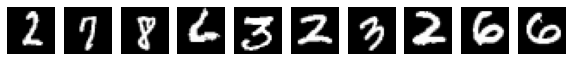

Reconstructions:


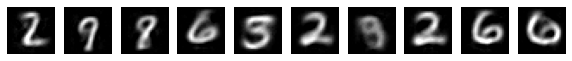

Generated Images:


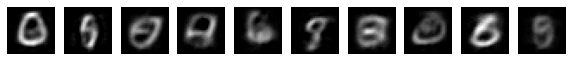

Train | Epoch: 20 [0/60000 (0%)]	Loss: 33.156197
Train | Epoch: 20 [12800/60000 (21%)]	Loss: 32.832718
Train | Epoch: 20 [25600/60000 (43%)]	Loss: 31.702152
Train | Epoch: 20 [38400/60000 (64%)]	Loss: 32.889614
Train | Epoch: 20 [51200/60000 (85%)]	Loss: 32.614510
====> Train | Epoch: 20 	 | 	 Average loss: 32.9438
====> Test  | model loss: 32.1977
Inputs:


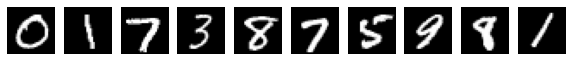

Reconstructions:


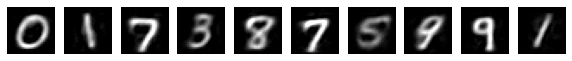

Generated Images:


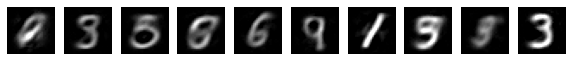

Train | Epoch: 21 [0/60000 (0%)]	Loss: 33.889557
Train | Epoch: 21 [12800/60000 (21%)]	Loss: 33.833855
Train | Epoch: 21 [25600/60000 (43%)]	Loss: 33.156315
Train | Epoch: 21 [38400/60000 (64%)]	Loss: 31.479647
Train | Epoch: 21 [51200/60000 (85%)]	Loss: 33.059742
====> Train | Epoch: 21 	 | 	 Average loss: 32.7812
====> Test  | model loss: 32.0969
Inputs:


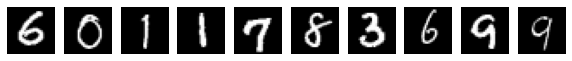

Reconstructions:


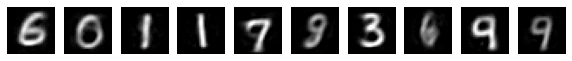

Generated Images:


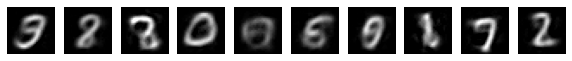

Train | Epoch: 22 [0/60000 (0%)]	Loss: 33.483009
Train | Epoch: 22 [12800/60000 (21%)]	Loss: 32.668468
Train | Epoch: 22 [25600/60000 (43%)]	Loss: 34.257896
Train | Epoch: 22 [38400/60000 (64%)]	Loss: 31.719719
Train | Epoch: 22 [51200/60000 (85%)]	Loss: 31.787300
====> Train | Epoch: 22 	 | 	 Average loss: 32.6164
====> Test  | model loss: 31.9701
Inputs:


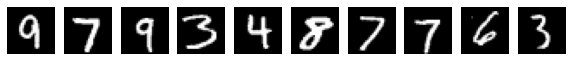

Reconstructions:


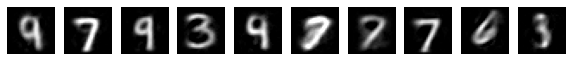

Generated Images:


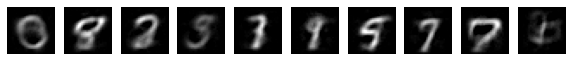

Train | Epoch: 23 [0/60000 (0%)]	Loss: 32.350830
Train | Epoch: 23 [12800/60000 (21%)]	Loss: 33.004021
Train | Epoch: 23 [25600/60000 (43%)]	Loss: 32.322479
Train | Epoch: 23 [38400/60000 (64%)]	Loss: 33.620243
Train | Epoch: 23 [51200/60000 (85%)]	Loss: 33.152824
====> Train | Epoch: 23 	 | 	 Average loss: 32.4919
====> Test  | model loss: 31.7608
Inputs:


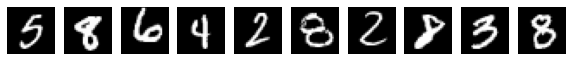

Reconstructions:


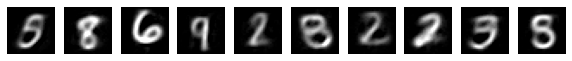

Generated Images:


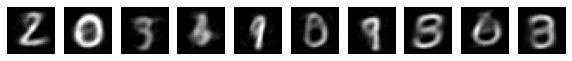

Train | Epoch: 24 [0/60000 (0%)]	Loss: 31.046005
Train | Epoch: 24 [12800/60000 (21%)]	Loss: 31.384390
Train | Epoch: 24 [25600/60000 (43%)]	Loss: 31.576466
Train | Epoch: 24 [38400/60000 (64%)]	Loss: 31.142952
Train | Epoch: 24 [51200/60000 (85%)]	Loss: 33.900112
====> Train | Epoch: 24 	 | 	 Average loss: 32.3060
====> Test  | model loss: 31.6532
Inputs:


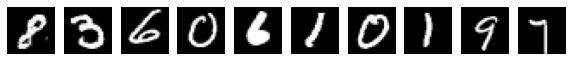

Reconstructions:


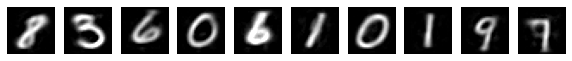

Generated Images:


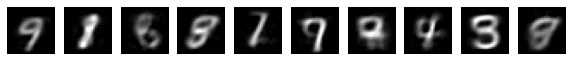

Train | Epoch: 25 [0/60000 (0%)]	Loss: 30.566555
Train | Epoch: 25 [12800/60000 (21%)]	Loss: 32.883408
Train | Epoch: 25 [25600/60000 (43%)]	Loss: 31.176525
Train | Epoch: 25 [38400/60000 (64%)]	Loss: 31.429333
Train | Epoch: 25 [51200/60000 (85%)]	Loss: 32.521702
====> Train | Epoch: 25 	 | 	 Average loss: 32.1974
====> Test  | model loss: 31.4119
Inputs:


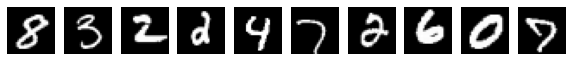

Reconstructions:


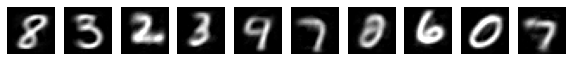

Generated Images:


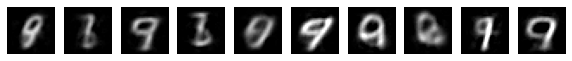

Train | Epoch: 26 [0/60000 (0%)]	Loss: 33.962589
Train | Epoch: 26 [12800/60000 (21%)]	Loss: 32.740417
Train | Epoch: 26 [25600/60000 (43%)]	Loss: 33.184208
Train | Epoch: 26 [38400/60000 (64%)]	Loss: 31.597383
Train | Epoch: 26 [51200/60000 (85%)]	Loss: 31.647284
====> Train | Epoch: 26 	 | 	 Average loss: 32.0769
====> Test  | model loss: 31.3588
Inputs:


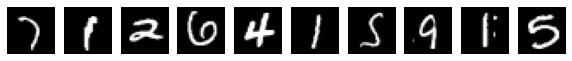

Reconstructions:


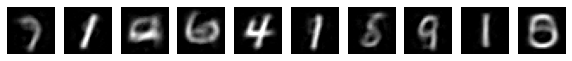

Generated Images:


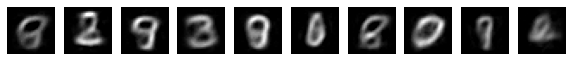

Train | Epoch: 27 [0/60000 (0%)]	Loss: 31.957687
Train | Epoch: 27 [12800/60000 (21%)]	Loss: 32.649197
Train | Epoch: 27 [25600/60000 (43%)]	Loss: 31.724110
Train | Epoch: 27 [38400/60000 (64%)]	Loss: 30.796606
Train | Epoch: 27 [51200/60000 (85%)]	Loss: 33.029869
====> Train | Epoch: 27 	 | 	 Average loss: 31.9690
====> Test  | model loss: 31.3240
Inputs:


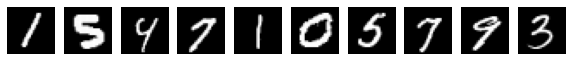

Reconstructions:


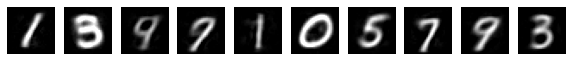

Generated Images:


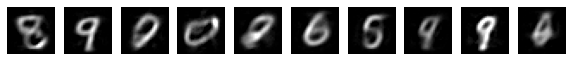

Train | Epoch: 28 [0/60000 (0%)]	Loss: 29.768795
Train | Epoch: 28 [12800/60000 (21%)]	Loss: 32.811687
Train | Epoch: 28 [25600/60000 (43%)]	Loss: 31.754614
Train | Epoch: 28 [38400/60000 (64%)]	Loss: 32.862900
Train | Epoch: 28 [51200/60000 (85%)]	Loss: 31.382847
====> Train | Epoch: 28 	 | 	 Average loss: 31.8556
====> Test  | model loss: 31.1730
Inputs:


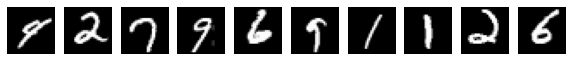

Reconstructions:


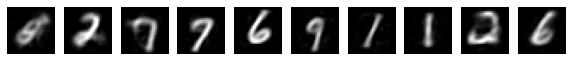

Generated Images:


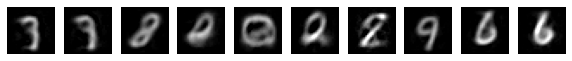

Train | Epoch: 29 [0/60000 (0%)]	Loss: 30.509146
Train | Epoch: 29 [12800/60000 (21%)]	Loss: 31.615047
Train | Epoch: 29 [25600/60000 (43%)]	Loss: 32.305420
Train | Epoch: 29 [38400/60000 (64%)]	Loss: 31.701218
Train | Epoch: 29 [51200/60000 (85%)]	Loss: 31.104921
====> Train | Epoch: 29 	 | 	 Average loss: 31.7433
====> Test  | model loss: 31.1419
Inputs:


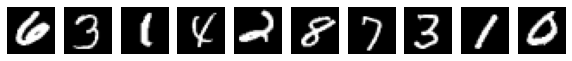

Reconstructions:


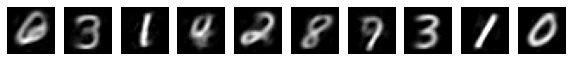

Generated Images:


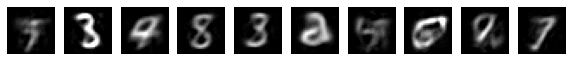

Train | Epoch: 30 [0/60000 (0%)]	Loss: 33.950100
Train | Epoch: 30 [12800/60000 (21%)]	Loss: 32.005470
Train | Epoch: 30 [25600/60000 (43%)]	Loss: 32.368958
Train | Epoch: 30 [38400/60000 (64%)]	Loss: 32.148777
Train | Epoch: 30 [51200/60000 (85%)]	Loss: 32.295532
====> Train | Epoch: 30 	 | 	 Average loss: 31.6526
====> Test  | model loss: 31.0350
Inputs:


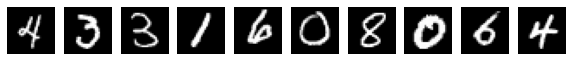

Reconstructions:


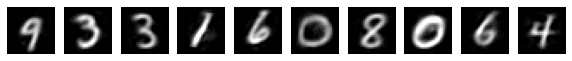

Generated Images:


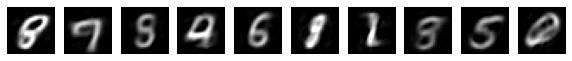

In [51]:
n_epoch = 30
run(vae, vae.parameters(), n_epoch, train_loader, test_loader,
   end_function=show_vae)

---

In [79]:
def check_interpolations(model, n_rows, n_cols):
    """
    Write a function which interpolates 10 images between two random mnist image
    """
    plt.rcParams['figure.figsize'] = (0.0 + n_cols, 0.0 + n_rows) # set default size of plots
    
    data_loader = train_loader
    
    for _ in range(n_rows):
        indices = torch.randint(data_loader.dataset.tensors[0].shape[0], (2,))
        img_1 = data_loader.dataset.tensors[0][indices][:1].flatten(start_dim=1)
        img_2 = data_loader.dataset.tensors[0][indices][1:].flatten(start_dim=1)
        
        ########################## TODO ##########################
        # Output `n_cols` images.
        # First one should be img_1. Last one should by img_2
        # Let z_1 and z_2 be latent tensors of img_1 and img_2
        # Interpolate (n_cols - 2) tensors between z_1 and z_2
        # Intermediate images must be the result of applying decoder on these (n_cols - 2) tensors
        z_1 = vae({"X": img_1.cuda()})['z']
        z_2 = vae({"X": img_2.cuda()})['z']
        delta = z_2 - z_1
        zs = [z_1 + i*delta/(n_cols-1) for i in range(n_cols)]
        output = np.array([model.decoder(zs[i]).detach().cpu().view(28, 28).numpy() for i in range(len(zs))])
        ######################## END TODO ########################
        
        show(output)

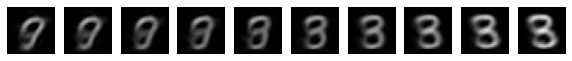

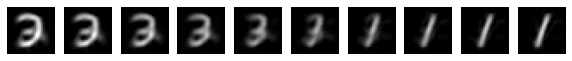

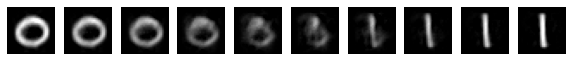

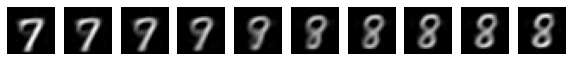

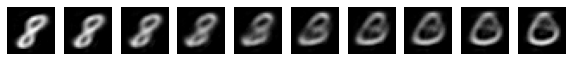

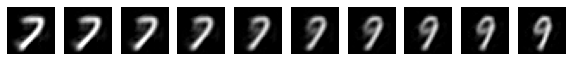

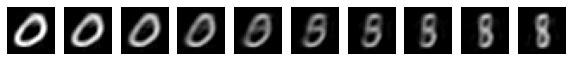

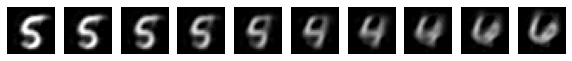

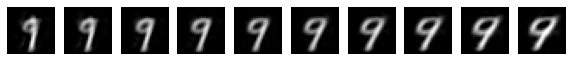

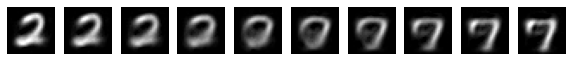

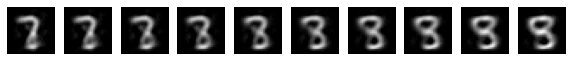

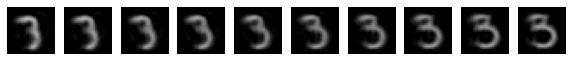

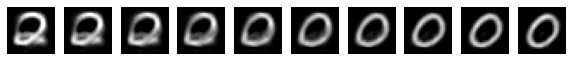

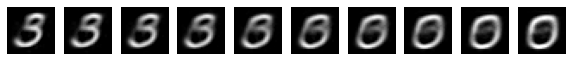

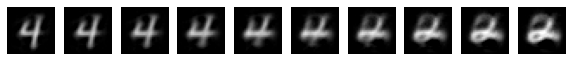

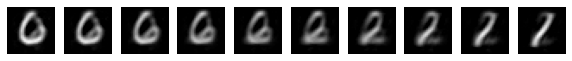

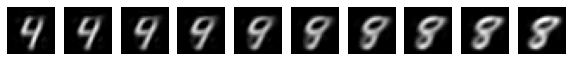

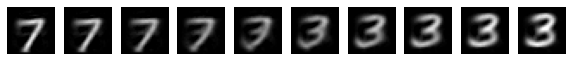

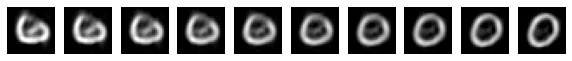

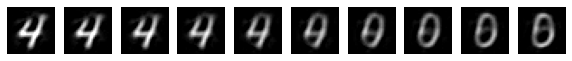

In [80]:
check_interpolations(vae, 20, 10)